In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from collections import Counter
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras import losses
from scipy import stats
import tensorflow as tf
from keras.models import Model,load_model,Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras import regularizers, optimizers
from sklearn.metrics import confusion_matrix,auc,roc_curve,roc_auc_score
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import datetime as dt
from sklearn import preprocessing
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback

sns.set(style="whitegrid")
np.random.seed(203)

train_data = pd.read_csv('/content/gdrive/MyDrive/fraudTrain.csv')
test_data = pd.read_csv('/content/gdrive/MyDrive/fraudTest.csv')
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)
train=train_data
test=test_data

In [6]:
train['month'] = pd.to_datetime(train['trans_date_trans_time']).dt.month
train['day'] = pd.to_datetime(train['trans_date_trans_time']).dt.dayofweek
train['hour'] = pd.to_datetime(train['trans_date_trans_time']).dt.hour
train['age'] = dt.date.today().year - pd.to_datetime(train['dob']).dt.year
train_new = train[['category','state' ,'amt','zip', 'lat', 'long', 'city_pop','merch_lat','merch_long','age', 'hour', 'day', 'month', 'is_fraud']]
# train

In [7]:
test['month'] = pd.to_datetime(test['trans_date_trans_time']).dt.month
test['day'] = pd.to_datetime(test['trans_date_trans_time']).dt.dayofweek
test['hour'] = pd.to_datetime(test['trans_date_trans_time']).dt.hour
test['age'] = dt.date.today().year - pd.to_datetime(test['dob']).dt.year
test_new = test[['category','state','amt','zip', 'lat', 'long','city_pop','merch_lat','merch_long','age', 'hour', 'day', 'month', 'is_fraud']]

In [64]:
train_new.head()

,category,state,amt,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,day,month,is_fraud
0,misc_net,NC,4.97,28654,36.0788,-81.1781,3495,36.011293,-82.048315,35,0,1,1,0.0
1,grocery_pos,WA,107.23,99160,48.8878,-118.2105,149,49.159047,-118.186462,45,0,1,1,0.0
2,entertainment,ID,220.11,83252,42.1808,-112.2620,4154,43.150704,-112.154481,61,0,1,1,0.0
3,gas_transport,MT,45.00,59632,46.2306,-112.1138,1939,47.034331,-112.561071,56,0,1,1,0.0
4,misc_pos,VA,41.96,24433,38.4207,-79.4629,99,38.674999,-78.632459,37,0,1,1,0.0


In [8]:
# all rows and all columns (except the last column)
creditCardData = train_new.iloc[:, :-1].values
# all rows and the last column => NOTE: storing all the result value
creditCardLabels = train_new.iloc[:, -1].values

In [9]:
creditCardData.shape

(15592, 13)

In [10]:
categorical_columns = [0,1]
numeric_columns = [2,3, 4, 5, 6, 7,8,9 , 10 ,11, 12]

# Use one-hot encoding for the 'category' column
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_columns)
])
# Apply preprocessing
creditCardFeatures = preprocessor.fit_transform(creditCardData)

In [13]:
creditCardFeatures.shape

(15592, 73)

In [14]:
#using SMOTE method to solve the imbalance problem
sm = SMOTE(random_state=42)
creditCardFeatures_sampled,creditCardLabels_sampled=sm.fit_resample(creditCardFeatures,creditCardLabels)

In [15]:
counts=pd.value_counts(creditCardLabels_sampled)
print(counts)

0.0    15492
1.0    15492
dtype: int64


###Building Model

In [16]:
# <0.8 is a comparison that checks if the generated random numbers are less than 0.8.
#This comparison results in a boolean array where each element is True if the corresponding
#random number is less than 0.8 and False otherwise.

#So, we are randomly assigning 80% of your data points to the training set
# and the remaining 20% to the test set based on these randomly generated numbers.

test_train_msk = np.random.rand(len(creditCardLabels_sampled)) < 0.8

x_train = creditCardFeatures_sampled[test_train_msk]
y_train = creditCardLabels_sampled[test_train_msk]

x_test = creditCardFeatures_sampled[~test_train_msk]
y_test = creditCardLabels_sampled[~test_train_msk]

In [15]:
train_split_msk = np.random.rand(len(x_train)) < 0.5

x_train_unsupervised = x_train[train_split_msk]
y_train_unsupervised = y_train[train_split_msk]

x_train_supervised = x_train[~train_split_msk]
y_train_supervised = y_train[~train_split_msk]

In [16]:
counts1= pd.value_counts(y_train_supervised)
print(counts1)

1.0    6202
0.0    6147
dtype: int64


In [17]:
x_test.shape

(6177, 73)

In [18]:
x_train_unsupervised.shape

(12458, 73)

In [19]:
x_train_supervised.shape

(12349, 73)

In [22]:
#vverbose = A value of 1 means that you will receive progress messages about the training process.
# save_best_only= When set to True, this ensures that the model weights are saved only when the monitored metric (in this case, validation accuracy) improves.
# mode =  it's set to 'max' because we want to save the model with the highest validation accuracy.
checkpoint = ModelCheckpoint('frauddetectionmodel.h5',monitor='val_acc',verbose=1,save_best_only=True,mode='max')

#initialally, we have 73 features
input_rec=Input(shape= (73,))
#Hidden layers

encoder = Dense(37,activation ='tanh')(input_rec)  #dense layer 1 in encoder
encoder = Dense(18,activation ='relu')(encoder)    #dense layer 2 in encoder
decoder = Dense(37,activation ='tanh')(encoder)    #dense layer 1 in decoder
decoder = Dense(73,activation ='relu')(decoder)    #dense layer 2 in decoder

encoder = Model(input_rec,encoder)        #Encoder model. we are not using this.
#Build Model
autoencoder = Model(input_rec, decoder)   #Full Model

#using RMSPROP as optimizer
rmsprop = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001,rho=0.9,epsilon=None,decay=0.0)
# adam = Adam(learning_rate=0.001)

autoencoder.compile(loss=losses.mean_squared_error,
                    optimizer=rmsprop,
                    metrics=['mse','acc'])

#Training
history = autoencoder.fit(
    x_train_unsupervised,x_train_unsupervised,
    batch_size=30,
    shuffle=True,
    callbacks=[checkpoint],
    epochs=200,
    validation_data=(x_test,x_test))

Epoch 1/200
410/416 [============================>.] - ETA: 0s - loss: 0.1720 - mse: 0.1720 - acc: 0.6046
Epoch 1: val_acc improved from -inf to 0.75409, saving model to frauddetectionmodel.h5
416/416 [==============================] - 10s 16ms/step - loss: 0.1717 - mse: 0.1717 - acc: 0.6074 - val_loss: 0.1307 - val_mse: 0.1307 - val_acc: 0.7541
Epoch 2/200
405/416 [============================>.] - ETA: 0s - loss: 0.1284 - mse: 0.1284 - acc: 0.7833
Epoch 2: val_acc improved from 0.75409 to 0.79246, saving model to frauddetectionmodel.h5
416/416 [==============================] - 3s 7ms/step - loss: 0.1282 - mse: 0.1282 - acc: 0.7843 - val_loss: 0.1247 - val_mse: 0.1247 - val_acc: 0.7925
Epoch 3/200
404/416 [============================>.] - ETA: 0s - loss: 0.1239 - mse: 0.1239 - acc: 0.8225
Epoch 3: val_acc improved from 0.79246 to 0.83779, saving model to frauddetectionmodel.h5
416/416 [==============================] - 2s 5ms/step - loss: 0.1239 - mse: 0.1239 - acc: 0.8233 - val_los

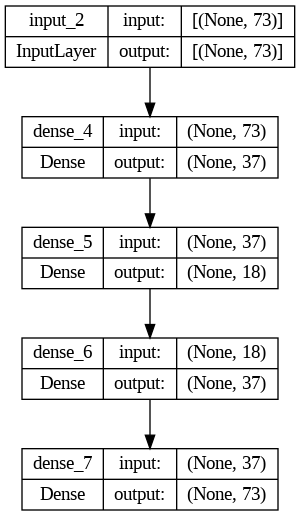

In [70]:
from tensorflow.keras.utils import plot_model

# Visualize the model and save it to a file
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True, show_layer_names=True)


###Loading the best autoencoder model

In [23]:
frauddetection_ae=load_model('frauddetectionmodel.h5')

In [24]:
frauddetection_ae.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 73)]              0         
                                                                 
 dense_4 (Dense)             (None, 37)                2738      
                                                                 
 dense_5 (Dense)             (None, 18)                684       
                                                                 
 dense_6 (Dense)             (None, 37)                703       
                                                                 
 dense_7 (Dense)             (None, 73)                2774      
                                                                 
Total params: 6899 (26.95 KB)
Trainable params: 6899 (26.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
for layer in frauddetection_ae.layers:
  print(layer.name)

input_2
dense_4
dense_5
dense_6
dense_7


In [26]:
frauddetection_ae.layers[4].name

'dense_7'

In [27]:
frauddetection_ae.layers[4].output

<KerasTensor: shape=(None, 73) dtype=float32 (created by layer 'dense_7')>

In [28]:
class_model=Model(inputs = frauddetection_ae.input, outputs=frauddetection_ae.get_layer(frauddetection_ae.layers[4].name).output)

In [29]:
class_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 73)]              0         
                                                                 
 dense_4 (Dense)             (None, 37)                2738      
                                                                 
 dense_5 (Dense)             (None, 18)                684       
                                                                 
 dense_6 (Dense)             (None, 37)                703       
                                                                 
 dense_7 (Dense)             (None, 73)                2774      
                                                                 
Total params: 6899 (26.95 KB)
Trainable params: 6899 (26.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
predictions= frauddetection_ae.predict(x_test)

mse= np.mean(np.power(x_test - predictions,2),axis=1)

loss = pd.DataFrame({'error':mse,
                     'actuals':y_test})
loss.describe()

194/194 [==============================] - 0s 1ms/step


,error,actuals
count,6177.000000,6177.000000
mean,0.116729,0.491339
std,0.193319,0.499965
min,0.000573,0.000000
25%,0.035480,0.000000
50%,0.054717,0.000000
75%,0.091335,1.000000
max,0.991975,1.000000


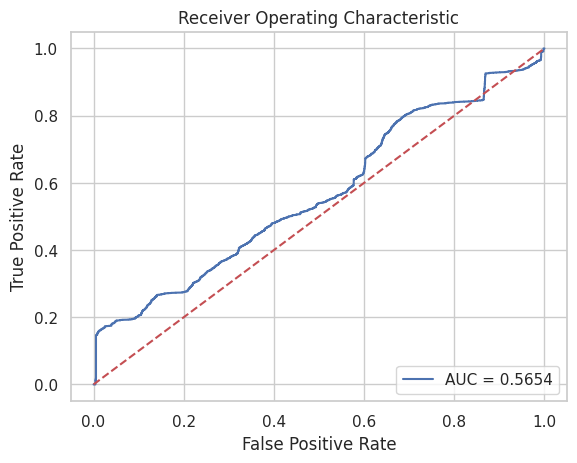

In [31]:
fpr,tpr,thresholds = roc_curve(loss.actuals,loss.error)

roc_auc = auc(fpr,tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label ='AUC = %0.4f'%roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

###Classification Model

In [32]:
frauddetection_cfn_model = Sequential()
frauddetection_cfn_model.add(class_model)

frauddetection_cfn_model.add(Dense(256,activation='tanh'))

frauddetection_cfn_model.add(Dense(1,activation='sigmoid'))

In [33]:
checkpoint2 = ModelCheckpoint('frauddetection_classification.h5', monitor = 'val_acc', verbose = 1, save_best_only=True, mode ='max')
frauddetection_cfn_model.compile(loss=losses.mean_squared_error,
                                 optimizer = 'adam',
                                 metrics=['mse','acc'])

fraudetection_history = frauddetection_cfn_model.fit(
    x_train_supervised, y_train_supervised,
    batch_size = 30,
    shuffle = True,
    callbacks = [checkpoint2],
    epochs = 50,
    validation_data=(x_test,y_test))

Epoch 1/50
411/412 [============================>.] - ETA: 0s - loss: 0.0239 - mse: 0.0239 - acc: 0.9715
Epoch 1: val_acc improved from -inf to 0.99498, saving model to frauddetection_classification.h5
412/412 [==============================] - 3s 5ms/step - loss: 0.0238 - mse: 0.0238 - acc: 0.9715 - val_loss: 0.0044 - val_mse: 0.0044 - val_acc: 0.9950
Epoch 2/50
 33/412 [=>............................] - ETA: 1s - loss: 0.0043 - mse: 0.0043 - acc: 0.9960

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


410/412 [============================>.] - ETA: 0s - loss: 0.0049 - mse: 0.0049 - acc: 0.9947
Epoch 2: val_acc improved from 0.99498 to 0.99531, saving model to frauddetection_classification.h5
412/412 [==============================] - 2s 6ms/step - loss: 0.0049 - mse: 0.0049 - acc: 0.9947 - val_loss: 0.0037 - val_mse: 0.0037 - val_acc: 0.9953
Epoch 3/50
409/412 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 0.0036 - acc: 0.9957
Epoch 3: val_acc did not improve from 0.99531
412/412 [==============================] - 3s 7ms/step - loss: 0.0037 - mse: 0.0037 - acc: 0.9955 - val_loss: 0.0041 - val_mse: 0.0041 - val_acc: 0.9948
Epoch 4/50
406/412 [============================>.] - ETA: 0s - loss: 0.0026 - mse: 0.0026 - acc: 0.9968
Epoch 4: val_acc improved from 0.99531 to 0.99563, saving model to frauddetection_classification.h5
412/412 [==============================] - 2s 5ms/step - loss: 0.0026 - mse: 0.0026 - acc: 0.9968 - val_loss: 0.0035 - val_mse: 0.0035 - val_acc

Predictions

In [34]:
frauddetection_classification = load_model('frauddetection_classification.h5')

y_test_preds = pd.DataFrame(frauddetection_classification.predict(x_test))
y_test_pred = y_test_preds.apply(lambda x: x>=0.5)
y_test_pred = y_test_pred.astype(int)

194/194 [==============================] - 0s 2ms/step


In [36]:
y=y_test.astype(int).reshape(6177,1)

Mosaic Plot

In [37]:
concantenatd = pd.DataFrame(np.concatenate((y_test_pred,y),axis=1))
concantenatd.columns = ['Predicted','Actual']

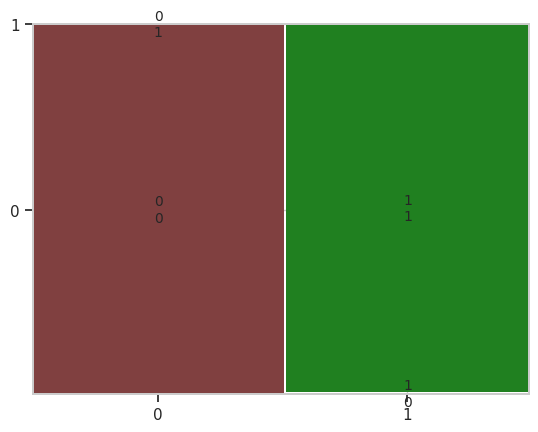

In [38]:
ax=mosaic(concantenatd,['Predicted','Actual'],gap=0.005)

###Confusion Matrix

In [39]:
#confusion matrix
cnf_matrix = confusion_matrix(y_test_pred,y_test)

In [40]:
cnf_matrix

array([[3138,    0],
       [   4, 3035]])

In [43]:
from itertools import product

Text(0.5, -15.71263972600328, 'Predicted Label')

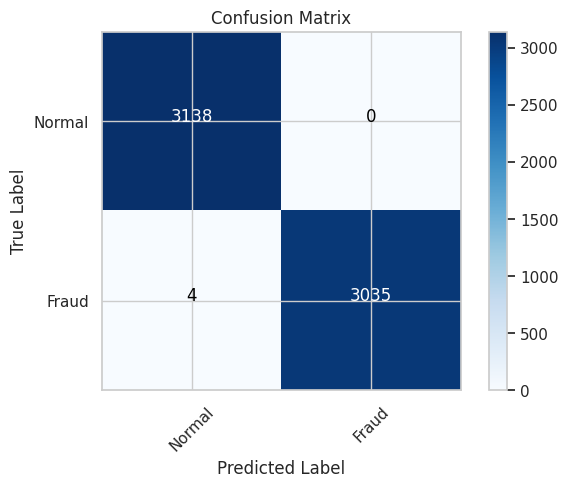

In [50]:
classes=['Normal','Fraud']
plt.imshow(cnf_matrix,interpolation='nearest',cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks,classes,rotation=45)
plt.yticks(tick_marks,classes)

thresh = cnf_matrix.max() / 2.
for i,j in product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i,j], 'd'),
               horizontalalignment = "center",
               color = "white" if cnf_matrix[i,j]>thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


In [52]:
pipe3 = Pipeline(steps=[
    ('step1', preprocessor)
])

In [55]:
# import pickle
# pickle.dump(preprocessor,open('preprocessor.pkl','wb'))

In [51]:
frauddetection_classification.save("AutoEncoder.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
fraudulent_samples = train_new[train['is_fraud'] == 1]
fraudulent_samples=fraudulent_samples[0:5]
fraudulent_samples

,category,state,amt,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,day,month,is_fraud
2449,grocery_pos,NC,281.06,28611,35.9946,-81.7266,885,36.430124,-81.179483,35,1,2,1,1.0
2472,gas_transport,TX,11.52,78208,29.4400,-98.4590,1595797,29.819364,-99.142791,63,1,2,1,1.0
2523,grocery_pos,TX,276.31,78208,29.4400,-98.4590,1595797,29.273085,-98.836360,63,3,2,1,1.0
2546,gas_transport,NC,7.03,28611,35.9946,-81.7266,885,35.909292,-82.091010,35,3,2,1,1.0
2553,grocery_pos,TX,275.73,78208,29.4400,-98.4590,1595797,29.786426,-98.683410,63,3,2,1,1.0


In [29]:
fraudulent_samples=fraudulent_samples.iloc[:, :-1]
fraudulent_samples

,category,state,amt,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,day,month
2449,grocery_pos,NC,281.06,28611,35.9946,-81.7266,885,36.430124,-81.179483,35,1,2,1
2472,gas_transport,TX,11.52,78208,29.4400,-98.4590,1595797,29.819364,-99.142791,63,1,2,1
2523,grocery_pos,TX,276.31,78208,29.4400,-98.4590,1595797,29.273085,-98.836360,63,3,2,1
2546,gas_transport,NC,7.03,28611,35.9946,-81.7266,885,35.909292,-82.091010,35,3,2,1
2553,grocery_pos,TX,275.73,78208,29.4400,-98.4590,1595797,29.786426,-98.683410,63,3,2,1


In [67]:
data=preprocessor.transform(fraudulent_samples)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


In [68]:
frauddetection_classification.predict(data)

1/1 [==============================] - 0s 35ms/step


array([[0.9999737],
       [1.       ],
       [1.       ],
       [0.9999951],
       [1.       ]], dtype=float32)

In [33]:
import pickle
with open('logisticRegression.pkl', 'rb') as model_file:
    logistic_model = pickle.load(model_file)
with open('RandomForest.pkl', 'rb') as model_file:
    random_forest = pickle.load(model_file)
with open('SVC.pkl', 'rb') as model_file:
    svc = pickle.load(model_file)

In [ ]:
with open('pipe2.pkl', 'rb') as model_file:
    random_forest = pickle.load(model_file)

In [35]:
AutoEncoder_model =load_model('AutoEncoder.h5')

In [24]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

In [38]:
# Create a Voting Classifier
ensemble_model = VotingClassifier(estimators=[
    ('linear', logistic_model),
    ('random_forest', random_forest),
    ('svc', svc)
], voting='hard')

# Fit the ensemble model on the training data
ensemble_model.fit(creditCardFeatures_sampled, creditCardLabels_sampled)

# Make predictions on the validation set
ensemble_predictions = ensemble_model.predict(x_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, ensemble_predictions)
print("Ensemble Model Accuracy:", accuracy)

Ensemble Model Accuracy: 0.9698882952889752


In [40]:
ensemble = Pipeline(steps=[
    ('step1', preprocessor),
    ('step2', ensemble_model)
])

In [43]:
import pickle
pickle.dump(ensemble,open('ensemble.pkl','wb'))